In [7]:
import os
import numpy as np

data = 'archive/Garbage classification/Garbage classification'

print(os.listdir(data))
from PIL import Image

png_filepath = data + '/paper/paper312.jpg'
png_pil_img = Image.open(png_filepath)
png_np_img = np.asarray(png_pil_img)

['paper', '.DS_Store', 'metal', 'cardboard', 'trash', 'glass', 'plastic']


In [16]:
png_np_img.T.shape

(3, 512, 384)

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 64 # Make this number of images or do actual BGD
target_size = (128, 128) # Make this smaller

train = ImageDataGenerator(horizontal_flip=True, vertical_flip=True,validation_split=0.1,rescale=1./255,
                         shear_range = 0.1,zoom_range = 0.1,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,)

test =ImageDataGenerator(rescale=1./255,validation_split=0.1)

train_generator = train.flow_from_directory(
    data,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical',
    subset = 'training'
)

test_generator = test.flow_from_directory(
    data,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical',
    subset = 'validation'
)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [53]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import models, layers
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout


def create_model():
    labels = list(train_generator.class_indices.keys())
    print(labels)
    num_classes = len(labels)

    # Build Model
    model = models.Sequential()


    model.add(layers.Conv2D(8,(3,3), padding='same', input_shape=(128, 128,3),activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2))) 
    model.add(BatchNormalization())
    model.add(Dropout(0.15)) 
    
    model.add(layers.Conv2D(16,(3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    #model.add(BatchNormalization())
    model.add(Dropout(0.15)) 

    model.add(layers.Conv2D(32,(3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64,(3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2))) 
    '''
    model.add(layers.Conv2D(32,(3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    model.add(layers.Conv2D(32,(3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2))) 
    '''
    model.add(layers.Flatten())
    model.add(layers.Dense(1024,activation='relu'))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dense(num_classes,activation='softmax'))

    # adding a dropout layer, batch normalization, early stopping
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
    checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    
    return model, checkpoint

In [54]:
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import ModelCheckpoint

# Create your model and checkpoint
model, checkpoint = create_model()

# Train the model using the training generator
history = model.fit(train_generator, epochs=10, validation_data=test_generator)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Epoch 1/10
36/36 [==============================] - 25s 646ms/step - loss: 1.7660 - accuracy: 0.2944 - val_loss: 1.7367 - val_accuracy: 0.1912
Epoch 2/10
36/36 [==============================] - 23s 624ms/step - loss: 1.4308 - accuracy: 0.4064 - val_loss: 1.7253 - val_accuracy: 0.3068
Epoch 3/10
36/36 [==============================] - 24s 673ms/step - loss: 1.3209 - accuracy: 0.4714 - val_loss: 1.7127 - val_accuracy: 0.3865
Epoch 4/10
36/36 [==============================] - 24s 665ms/step - loss: 1.2592 - accuracy: 0.5075 - val_loss: 1.6824 - val_accuracy: 0.4980
Epoch 5/10
36/36 [==============================] - 25s 679ms/step - loss: 1.1713 - accuracy: 0.5606 - val_loss: 1.5925 - val_accuracy: 0.5538
Epoch 6/10
36/36 [==============================] - 24s 661ms/step - loss: 1.1380 - accuracy: 0.5593 - val_loss: 1.6282 - val_accuracy: 0.3665
Epoch 7/10
36/36 [==============================] - 23s 626ms/step - loss: 1.0778

4/4 [==============================] - 1s 232ms/step


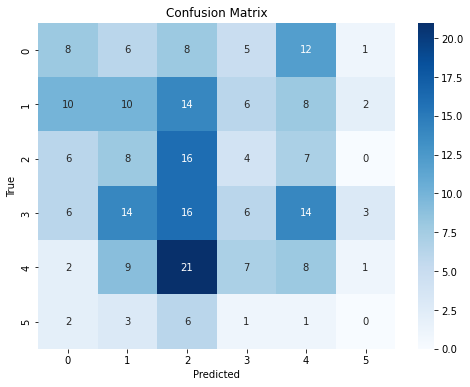

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the true labels and predicted labels for the test set
true_labels = test_generator.classes
predicted_labels = model.predict(test_generator).argmax(axis=1)

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Plotting training and validation loss
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
'''
Optimization
- add dropout, batch = 64, l2 weight normalization
''''''